<a href="https://colab.research.google.com/github/Feru34/Deep_Learning/blob/main/Talleres/Taller%202/Taller_2_Rueda_Felipe_Mijares_Alfredo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

# **Taller 2**

- **Integrante 1:** Felipe Rueda
- **Integrante 2:**

Bangladesh es una de los países con más tráfico en el mundo. Allí se encuentran algunas particularidades como los *rickshaw*, que son vehículos de 2 ruedas impulsados por una persona.

Los estudios indican que alrededos de 3.000 personas fallecen al año a causa de accidentes de tránsito.

Como consultor del sector de transporte, la organización ha procesado alrededor de 20.000 imágenes etiquetadas con información de objetos que pertenecen a las siguientes 13 clases:

* person
* rickshaw
* rickshaw van
* auto rickshaw
* truck
* pickup truck
* private car
* motorcycle
* bicycle
* bus
* micro bus
* covered van
* human hauler

Han sido contratados para buscar un proceso que permita acelerar el entendimiento de esta problemática, para el cuál le solicitan construir un modelo de detección de objetos que permita identificar los diferentes actores viales.

La información etiquetada se encuentra en  "[Bangladesh traffic](https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding)".

# **Preguntas:**

1.   Construir una red neuronal de detección de objetos usando un modelo pre-entrenado. Recuerden ser descriptivos en el Preprocesamiento de Datos, Utilización de Modelos Pre-entrenados, Evaluación de Rendimiento y búsqueda de hiperparámetros.

2.  Proporcionar algunos ejemplos de detección de objetos con la red entrenada y lo comparen con la imagen con los datos anotados. Traten de usar imágenes con 1 objeto asi como imágenes con varios objetos.

3.  Investigar la métrica mAP y cómo la interpreta para la red entrenada.

4. Calcular el número de escenarios (imágenes) que involucran personas en el conjunto de prueba.

# **Notas Importantes:**
- Pueden usar la versión de Yolo del laboratorio u otra distinta.
- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser `Taller_2_{Apellido_Nombre}_{Apellido_Nombre}` de cada integrante respectivamente.

# 1. Construir una red neuronal de detección de objetos usando un modelo pre-entrenado

## Utilización de librerías

In [ ]:
!rm -rf "/content/rsud20k-bangladesh-road-scene-understanding"
!rm -rf "/content/rsud20k-bangladesh-road-scene-understanding-Cleaned2"
!rm -rf "/content/runs"
!rm -rf "/content/rsud20k-bangladesh-road-scene-understanding.zip"
!rm -rf "/content/yolov8n.pt"

In [2]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.5/882.5 kB 28.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import albumentations as A
import ultralytics
import albumentations
import os
import os.path as osp
import random
import re
import shutil

#Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import display, Image
from IPython import display

from numpy import asarray

from PIL import Image

from ultralytics import YOLO

import os
import cv2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
!nvidia-smi

Tue Oct  8 22:49:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Preprocesamiento de datos

Para tener un mejor detalle sobre el comportamiento de la información, la organización ha dispuesto la información de la siguiente forma:

```python
Multi-Class Animal Detection.v1-yolov8.zip/
  train/
    images/
      a_image_1.png
      a_image_2.jpg
      .......    
    labels/
      a_image_1.txt
      a_image_2.txt
      .......
  valid/
    images/
      b_image_1.png
      b_image_2.jpg
      .......    
    labels/
      b_image_1.txt
      b_image_2.txt
      .......
  test/
    images/
      c_image_1.png
      c_image_2.jpg
      .......    
    labels/
      c_image_1.txt
      c_image_2.txt
      .......
```

### Parámetros generales y carga de la información

In [5]:
my_seed = 19 #Semilla para reproducibilidad
IMG_EXT = ['.jpg', '.jpeg', '.png', '.bmp'] #Extensiones válidas de imagen
TEXT_EXT = '.txt'
YOLO_VERSION = 'yolov8'

In [6]:
random.seed(my_seed)

### Configuración del entorno de kaggle.

Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [7]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 62 Oct  8 22:49 kaggle.json


Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [8]:
!kaggle datasets list

401 - Unauthorized - Unauthenticated


Una vez hemos asegurado la conectividad, procedemos a realizar el proceso de descarga de la información del negocio.

In [9]:
!kaggle datasets download -d hasibzunair/rsud20k-bangladesh-road-scene-understanding

Dataset URL: https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 10.2G/10.2G [08:22<00:00, 22.6MB/s]
100% 10.2G/10.2G [08:22<00:00, 21.8MB/s]


Para la información que vamos a descomprimir, es necesario crear un un directorio para que el contenido del archivo zip, se encuentre allí. Para este propósito, vamos a crear unas variables de manejo de archivos:

In [10]:
ROOT_DIR = '/content'
DATASET_NAME = 'rsud20k-bangladesh-road-scene-understanding'
SUB_DATASET_NAME = 'rsud20k'

Vamos ahora a generar una previsualización del comando de descompresión del archivo zip:

In [11]:
print(f"!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}")

!unzip rsud20k-bangladesh-road-scene-understanding.zip -d /content/rsud20k-bangladesh-road-scene-understanding


Ahora si vamos a consolidar el bloque de comandos con todos los pasos para la descompresión del archivo zip:

In [12]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

Streaming output truncated to the last 5000 lines.
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6370.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6371.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6372.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6373.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6374.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6375.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6376.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6377.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6378.txt  
  inflating: /content/

Generamos la ruta del directorio para cargar la información:

In [13]:
DATA_DIR_IMG = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}/images"
DATA_DIR_LBS = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}/labels"
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}"
print(DATA_DIR_IMG)
print(DATA_DIR_LBS)

/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels


Verificamos las rutas de cada uno de los directorios:

In [14]:
subdirs = ['train', 'test', 'val']

In [15]:
train_img_folder = osp.join(DATA_DIR_IMG, subdirs[0])
train_lbl_folder = osp.join(DATA_DIR_LBS, subdirs[0])
val_img_folder = osp.join(DATA_DIR_IMG, subdirs[2])
val_lbl_folder = osp.join(DATA_DIR_LBS, subdirs[2])
test_img_folder = osp.join(DATA_DIR_IMG, subdirs[1])
test_lbl_folder = osp.join(DATA_DIR_LBS, subdirs[1])

Vamos a visualizar las rutas de las carpetas:

In [16]:
folder_list = [train_img_folder, train_lbl_folder,
                val_img_folder, val_lbl_folder,
                test_img_folder, test_lbl_folder
]

print("Imprimimos las rutas de las carpetas:")
for fa in folder_list:
  print(fa)

Imprimimos las rutas de las carpetas:
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/train
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/val
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/val
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/test
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/test


In [17]:
folder_list = [train_img_folder, val_img_folder,
               test_img_folder
]

¿Necesitamos usar los tensores?, no en este caso, dado que la información ya está descargada, vamos a asegurar la taxonomía de la información que espera Yolo.

¿Debemos validar el tamaño de las imágenes?. Normalmente debe hacerse, para este proceso es posible hacer un recorrido sobre los archivos y contrastar con los metadatos. Como en este caso no ha sido suministrado por la organización, no realizaremos este proceso cruzado, imprimimos la información directamente desde las imágenes:

In [18]:
img_name_list = []
img_width_list = []
img_height_list = []
img_folder_list = []
img_format_list = []

for fa in folder_list:
  parent = os.path.dirname(fa)
  parent_name = os.path.basename(parent)
  for fname in os.listdir(fa):
    img_folder_list.append(parent_name)
    img_name_list.append(fname)
    img_path = osp.join(fa, fname)
    img_format_list = "ok" if osp.splitext(fname)[-1] in IMG_EXT else "not ok"

    with Image.open(img_path) as img:
      width, height = img.size
      img_width_list.append(width)
      img_height_list.append(height)

data_model = {"folder": img_folder_list, "image_name": img_name_list,
              "width": img_width_list, "height": img_height_list
              , "format": img_format_list}
report_df = pd.DataFrame(data=data_model)

Este pequeño gragmento del reporte nos demuestra una longitud importante en cuánto a los nombres de los archivos, en la medida que nos sea posible estaremos "truncando" los nombres para faciliar la presentación de la información.

In [19]:
report_df.head()

folder      image_name  width  height format
0  images  train12800.jpg   1920    1080     ok
1  images   train5740.jpg   1920    1080     ok
2  images    train564.jpg   1920    1080     ok
3  images  train16771.jpg   1920    1080     ok
4  images   train9080.jpg   1920    1080     ok

Las imagenes tiene un tamaño horizontal de 1080x1920, algo que no soporta Yolo. Por lo que cambiamos el tamaño de los archivos para que tengan un tamaño cuarado 640x640

In [20]:
# Función para aplicar letterbox y adaptar el tamaño de las imágenes
def letterbox_image(image, expected_size=(640, 640)):
    ih, iw = image.shape[:2]  # Alto y ancho de la imagen original
    eh, ew = expected_size  # Alto y ancho esperados para YOLO

    # Escala para mantener la proporción
    scale = min(ew / iw, eh / ih)
    nw, nh = int(iw * scale), int(ih * scale)

    # Redimensionar la imagen con el nuevo tamaño escalado
    image_resized = cv2.resize(image, (nw, nh))

    # Crear una nueva imagen con el tamaño esperado y rellenar los bordes con color (negro)
    new_image = cv2.copyMakeBorder(image_resized,
                                   top=(eh - nh) // 2,
                                   bottom=(eh - nh) // 2,
                                   left=(ew - nw) // 2,
                                   right=(ew - nw) // 2,
                                   borderType=cv2.BORDER_CONSTANT,
                                   value=(0, 0, 0))

    return new_image, scale, (ew - nw) // 2, (eh - nh) // 2  # Devolvemos también la escala y el padding

# Función para procesar las imágenes de un directorio
def process_images(input_dir, output_dir, expected_size=(640, 640)):
    image_info = {}
    for image_file in os.listdir(input_dir):
        if image_file.endswith((".png", ".jpg", ".jpeg")):  # Comprobar que sea una imagen
            image_path = os.path.join(input_dir, image_file)
            image = cv2.imread(image_path)

            if image is not None:
                # Aplicar letterbox y obtener la escala y el padding
                processed_image, scale, pad_w, pad_h = letterbox_image(image, expected_size=expected_size)

                # Guardar la nueva imagen procesada
                cv2.imwrite(os.path.join(output_dir, image_file), processed_image)
                image_info[image_file] = (scale, pad_w, pad_h)
                print(f"Imagen {image_file} procesada, guardada correctamente.")

    return image_info

# Función para actualizar las etiquetas después de aplicar letterbox
def update_labels(label_file, scale, pad_w, pad_h, orig_size, new_size=(640, 640)):
    with open(label_file, 'r') as f:
        lines = f.readlines()

    updated_labels = []
    orig_w, orig_h = orig_size  # Tamaño original de la imagen
    new_w, new_h = new_size     # Tamaño nuevo de la imagen después de letterbox

    for line in lines:
        data = line.strip().split()
        cls = int(data[0])
        x_center = float(data[1])
        y_center = float(data[2])
        width = float(data[3])
        height = float(data[4])

        # Convertimos las coordenadas normalizadas a las dimensiones originales
        x_center_orig = x_center * orig_w
        y_center_orig = y_center * orig_h
        width_orig = width * orig_w
        height_orig = height * orig_h

        # Ajustamos las coordenadas según el escalado y el padding
        x_center_new = (x_center_orig * scale + pad_w) / new_w
        y_center_new = (y_center_orig * scale + pad_h) / new_h
        width_new = (width_orig * scale) / new_w
        height_new = (height_orig * scale) / new_h

        # Aseguramos que las nuevas coordenadas estén dentro de los límites [0, 1]
        x_center_new = min(max(x_center_new, 0), 1)
        y_center_new = min(max(y_center_new, 0), 1)
        width_new = min(max(width_new, 0), 1)
        height_new = min(max(height_new, 0), 1)

        # Guardamos la nueva línea de etiquetas
        updated_labels.append(f"{cls} {x_center_new} {y_center_new} {width_new} {height_new}\n")

    # Guardamos las etiquetas actualizadas en el archivo original
    with open(label_file, 'w') as f:
        f.writelines(updated_labels)

# Función para procesar las etiquetas de un directorio
def process_labels(label_dir, image_info, orig_size, new_size=(640, 640)):
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            image_file = label_file.replace('.txt', '.jpg')  # Asumimos que las imágenes son .jpg
            if image_file in image_info:
                scale, pad_w, pad_h = image_info[image_file]
                label_path = os.path.join(label_dir, label_file)
                update_labels(label_path, scale, pad_w, pad_h, orig_size=orig_size, new_size=new_size)
                print(f"Etiquetas de {label_file} actualizadas correctamente.")

# Rutas para las imágenes y etiquetas
input_train_path = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/train/"
input_test_path = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/test/"
input_val_path = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/val/"

label_train_dir = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/"
label_test_dir = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/test/"
label_val_dir = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/val/"

original_size = (1080, 1920)  # Tamaño original de las imágenes (alto, ancho)
new_size = (640, 640)  # Nuevo tamaño de las imágenes después de letterbox

# Procesar imágenes y etiquetas de los directorios de train, test, val
train_image_info = process_images(input_train_path, input_train_path, expected_size=new_size)
test_image_info = process_images(input_test_path, input_test_path, expected_size=new_size)
val_image_info = process_images(input_val_path, input_val_path, expected_size=new_size)

process_labels(label_train_dir, train_image_info, orig_size=original_size, new_size=new_size)
process_labels(label_test_dir, test_image_info, orig_size=original_size, new_size=new_size)
process_labels(label_val_dir, val_image_info, orig_size=original_size, new_size=new_size)


Se han truncado las últimas 5000 líneas del flujo de salida.
Etiquetas de train3926.txt actualizadas correctamente.
Etiquetas de train4294.txt actualizadas correctamente.
Etiquetas de train9588.txt actualizadas correctamente.
Etiquetas de train2838.txt actualizadas correctamente.
Etiquetas de train11285.txt actualizadas correctamente.
Etiquetas de train1992.txt actualizadas correctamente.
Etiquetas de train10387.txt actualizadas correctamente.
Etiquetas de train13580.txt actualizadas correctamente.
Etiquetas de train15898.txt actualizadas correctamente.
Etiquetas de train17874.txt actualizadas correctamente.
Etiquetas de train5087.txt actualizadas correctamente.
Etiquetas de train11792.txt actualizadas correctamente.
Etiquetas de train5614.txt actualizadas correctamente.
Etiquetas de train7955.txt actualizadas correctamente.
Etiquetas de train5308.txt actualizadas correctamente.
Etiquetas de train15785.txt actualizadas correctamente.
Etiquetas de train16330.txt actualizadas correctamen

In [21]:
report_df.groupby(['folder', 'format', 'width', 'height']).size()

folder  format  width  height
images  ok      1920   1080      20334
dtype: int64

Con el anterior reporte, hemos podido confirmar para cada uno de los conjuntos de datos, cuáles son los tamaños de las imágenes, además si los archivos son válidos, ya que en caso de tener imágenes que no se puedan abrir o un archivo con extensión no válida, pueden ser un inconveniente en la construcción del modelo.

In [22]:
IMAGE_SIZE = 640

Vamos a definir una función que permita visualizar muestras de los datos

In [23]:
def show_img_matrix(image_list, show_axis=False):
  MAX_SIZE = 9
  if len(image_list) != MAX_SIZE:
    return

  plt.figure(figsize=(10, 10))

  for i in range(MAX_SIZE):
    img_file = image_list[i]
    img_name = osp.basename(img_file)
    ax = plt.subplot(3, 3, i + 1)
    if osp.exists(img_file) == True:
      plt.imshow(asarray(Image.open(img_file)))
      img = mpimg.imread(img_file)
    #Como los nombres son muy extensos, vamos a truncar a 20 caracteres.
    plt.title(img_name[:20])
    plt.axis("on" if show_axis == True else "on")

  plt.tight_layout()
  plt.show()

Podemos observar que la función anterior cuenta con un parámetro que permite controlar la visualización de los ejes en las imágenes. En caso que no sea especificado, no los mostrará en la matriz.

Preparamos la carpeta para los datos de entrenamiento:

In [24]:
img_list = [filename for filename in os.listdir(train_img_folder)]
img_count = len(img_list)
print(f"El número total de imágenes es: {img_count}")

El número total de imágenes es: 18681


El número total de imágenes es: 1400

In [25]:
random.shuffle(img_list)

In [26]:
img_fc_list = [osp.join(train_img_folder, filename) for filename in img_list]

Visualizamos la información de una muestra de los datos de entrenamiento:

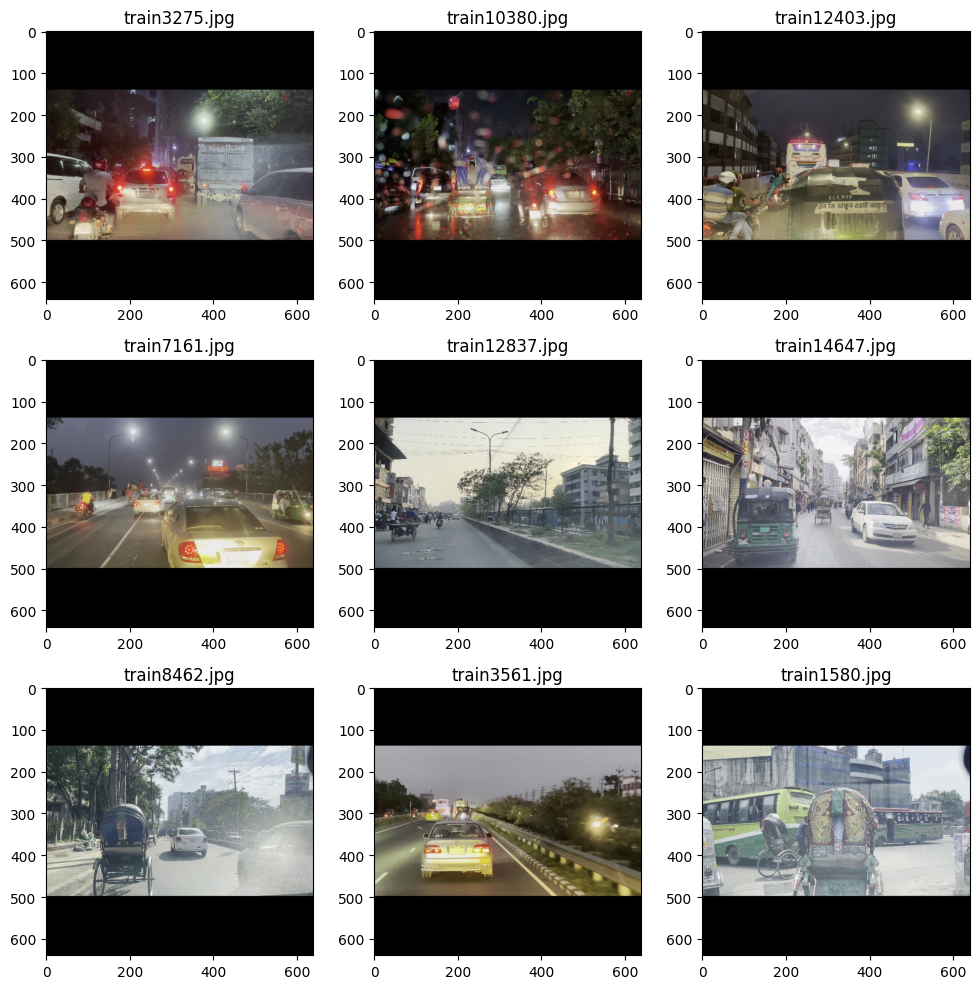

In [ ]:
show_img_matrix(img_fc_list[0:9], show_axis=True)

## Utilización de Modelos Pre-entrenados

Esta es la información de casos asociados a la problemática:
- person
- rickshaw
- rickshaw van
- auto rickshaw
- truck
- pickup truck
- private car
- motorcycle
- bicycle
- bus
- micro bus
- covered van
- human hauler

In [27]:
class_names = ["person", "rickshaw", "rickshaw van", "auto rickshaw", "truck",
               "pickup truck", "private car", "motorcycle", "bicycle", "bus",
               "micro bus", "covered van", "human hauler"
]

In [28]:
NEW_ROOT_DIR = f"{ROOT_DIR}/{DATASET_NAME}-Cleaned2"
print(DATA_DIR)

/content/rsud20k-bangladesh-road-scene-understanding/rsud20k


In [29]:
subdirs = ['train', 'test', 'val']
new_train_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[0])
new_val_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[2])
new_test_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[1])

img_tvt_folders = [train_img_folder, val_img_folder, test_img_folder]
new_img_tvt_folders = [new_train_folder, new_val_folder, new_test_folder]

In [30]:
for folder_path in new_img_tvt_folders:
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [31]:
for folder_path in new_img_tvt_folders:
  folder_path = folder_path.replace("/images", "/labels")
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Copiamos la información en la estructura que yolo espera:

In [32]:
for i in range(len(img_tvt_folders)):
  old_img_folder = img_tvt_folders[i]
  old_lbl_folder = img_tvt_folders[i].replace("/images", "/labels")
  new_lbl_folder = new_img_tvt_folders[i].replace("/images", "/labels")
  #Obtenemos el listado de archivos de la carpeta
  images = os.listdir(old_img_folder)
  #Los nombres del archivo de imagen y las etiquetas se diferencian por la extensión del archivo
  for img in images:
    #Información del origen de la imagen
    old_img_path = osp.join(old_img_folder, img)
    name, ext = os.path.splitext(old_img_path) #Extraemos la información del nombre y tipo del archivo
    old_lbl_path = osp.join(old_lbl_folder, img.replace(ext, TEXT_EXT))

    new_img_path = osp.join(new_img_tvt_folders[i], img)
    new_lbl_path = osp.join(new_lbl_folder, img.replace(ext, TEXT_EXT))

    if osp.exists(new_img_path) == True:
      os.remove(new_img_path)

    if osp.exists(new_lbl_path) == True:
      os.remove(new_lbl_path)

    #Copia la imagen
    shutil.copy(old_img_path, new_img_path)
    #Copia la etiqueta
    shutil.copy(old_lbl_path, new_lbl_path)

Yolo espera un archivo en formato YAML, que brinde la información sobre la información que acabamos de organizar, clases y otros.

In [33]:
YOLO_DIR = f'/content/{YOLO_VERSION}'

In [34]:
yaml_content = f"""\
path: {NEW_ROOT_DIR}   # dataset root dir
train: images/{osp.basename(new_img_tvt_folders[0])}  # train images (relative to 'path')
val: images/{osp.basename(new_img_tvt_folders[1])}  # val images (relative to 'path')
test: images/{osp.basename(new_img_tvt_folders[2])} # test images (optional)

# Classes
nc: {len(class_names)}

names: {class_names}
"""

YAML_PATH = f'{NEW_ROOT_DIR}/Bangladesh traffic.yaml'

if osp.exists(YAML_PATH):
  os.remove(YAML_PATH)

# Guardar el archivo YAML
with open(YAML_PATH, 'w') as yaml_file:
  yaml_file.write(yaml_content)

## Entrenamiento

Teniendo en cuenta que hemos instalado Yolo con el comando PIP, la instancia el modelo debe ser cargado de la siguiente forma:

In [35]:
model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 284MB/s]


Para entrenar el modelo, le damos la información del archivo YAML, el número de épocas, tamaño de la imagen y el batch. De forma opcional vamos a especificar el valor de la paciencia.

In [36]:
import glob

label_files = glob.glob('/content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/train/*.txt')
for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            parts = line.strip().split()

            if len(parts) != 5:
                print(f"Formato incorrecto en el archivo: {label_file}")
            else:
                class_id = parts[0]
                if not class_id.isdigit():
                    print(f"ID de clase no es un entero en el archivo: {label_file}")


In [37]:
model.train(data=YAML_PATH, epochs=20, imgsz=640, batch=16, patience=10, augment=False)

Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/Bangladesh traffic.yaml, epochs=20, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

100%|██████████| 755k/755k [00:00<00:00, 83.8MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 274MB/s]


AMP: checks passed ✅


train: Scanning /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/train... 18681 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18681/18681 [00:11<00:00, 1610.02it/s]


train: New cache created: /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/val... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:01<00:00, 810.74it/s]


val: New cache created: /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.71G      2.942      4.082      2.157         99        640: 100%|██████████| 1168/1168 [07:10<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


                   all       1004       7385      0.596     0.0312      0.026     0.0102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.97G      2.592      3.322      1.942         66        640: 100%|██████████| 1168/1168 [07:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


                   all       1004       7385      0.424     0.0523     0.0414     0.0146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.69G      2.469       3.04      1.872         84        640: 100%|██████████| 1168/1168 [06:45<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


                   all       1004       7385      0.597     0.0774     0.0736     0.0309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.64G       2.39      2.861      1.808         99        640: 100%|██████████| 1168/1168 [06:35<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


                   all       1004       7385      0.529     0.0905     0.0819     0.0363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.71G      2.304      2.707      1.746         76        640: 100%|██████████| 1168/1168 [06:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


                   all       1004       7385      0.442      0.106     0.0954     0.0443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.67G      2.239      2.586      1.703        106        640: 100%|██████████| 1168/1168 [06:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


                   all       1004       7385      0.527        0.1     0.0994     0.0495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.67G      2.185       2.49       1.67        122        640: 100%|██████████| 1168/1168 [06:24<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


                   all       1004       7385      0.264      0.132      0.117     0.0581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.68G      2.147      2.415       1.64         87        640: 100%|██████████| 1168/1168 [06:37<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


                   all       1004       7385      0.242      0.146      0.119     0.0606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.58G      2.094      2.331      1.607         98        640: 100%|██████████| 1168/1168 [06:43<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


                   all       1004       7385      0.339      0.143      0.142     0.0718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.79G      2.061      2.261      1.586        104        640: 100%|██████████| 1168/1168 [06:40<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


                   all       1004       7385      0.303      0.164      0.144     0.0723
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.38G      1.954      1.982       1.49         52        640: 100%|██████████| 1168/1168 [06:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


                   all       1004       7385      0.301      0.175      0.173     0.0918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.33G      1.883      1.876      1.447         38        640: 100%|██████████| 1168/1168 [06:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


                   all       1004       7385      0.348      0.186      0.179     0.0963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.34G      1.836      1.809      1.419         42        640: 100%|██████████| 1168/1168 [06:15<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


                   all       1004       7385      0.352      0.202      0.193      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.34G      1.795      1.746      1.393         51        640: 100%|██████████| 1168/1168 [06:17<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


                   all       1004       7385      0.348      0.187      0.182      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.33G      1.757      1.699      1.374         64        640: 100%|██████████| 1168/1168 [06:16<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all       1004       7385      0.401      0.188      0.193      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.34G       1.73      1.666      1.358         49        640: 100%|██████████| 1168/1168 [06:14<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


                   all       1004       7385      0.354      0.208      0.201      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.34G      1.692      1.626       1.34         53        640: 100%|██████████| 1168/1168 [06:29<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


                   all       1004       7385      0.361      0.208      0.201      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.34G      1.664      1.594      1.323         58        640: 100%|██████████| 1168/1168 [06:29<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


                   all       1004       7385      0.353      0.219      0.206      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.34G      1.641       1.57      1.312         56        640: 100%|██████████| 1168/1168 [06:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


                   all       1004       7385      0.391      0.211      0.212      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.33G      1.619      1.548      1.302         33        640: 100%|██████████| 1168/1168 [06:14<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


                   all       1004       7385      0.415      0.215      0.212       0.12

20 epochs completed in 2.243 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,686,903 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


                   all       1004       7385      0.412      0.215      0.212       0.12
                person        566       1917      0.491     0.0861      0.139     0.0603
              rickshaw        648       1587       0.63      0.397      0.448      0.274
          rickshaw van        160        240      0.419      0.113      0.116     0.0356
         auto rickshaw        388        590      0.606      0.407      0.435       0.26
                 truck         62         65       0.31     0.0923     0.0891     0.0505
          pickup truck         66         74      0.227      0.122     0.0798     0.0412
           private car        776       1420      0.687      0.429      0.459      0.255
            motorcycle        550        860       0.52      0.311      0.317      0.163
               bicycle        135        146      0.246     0.0479     0.0373     0.0124
                   bus        169        182      0.539      0.302      0.322      0.196
             micro bu

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d7d803fb50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

Veamos una muestra de los datos que entrenamos:

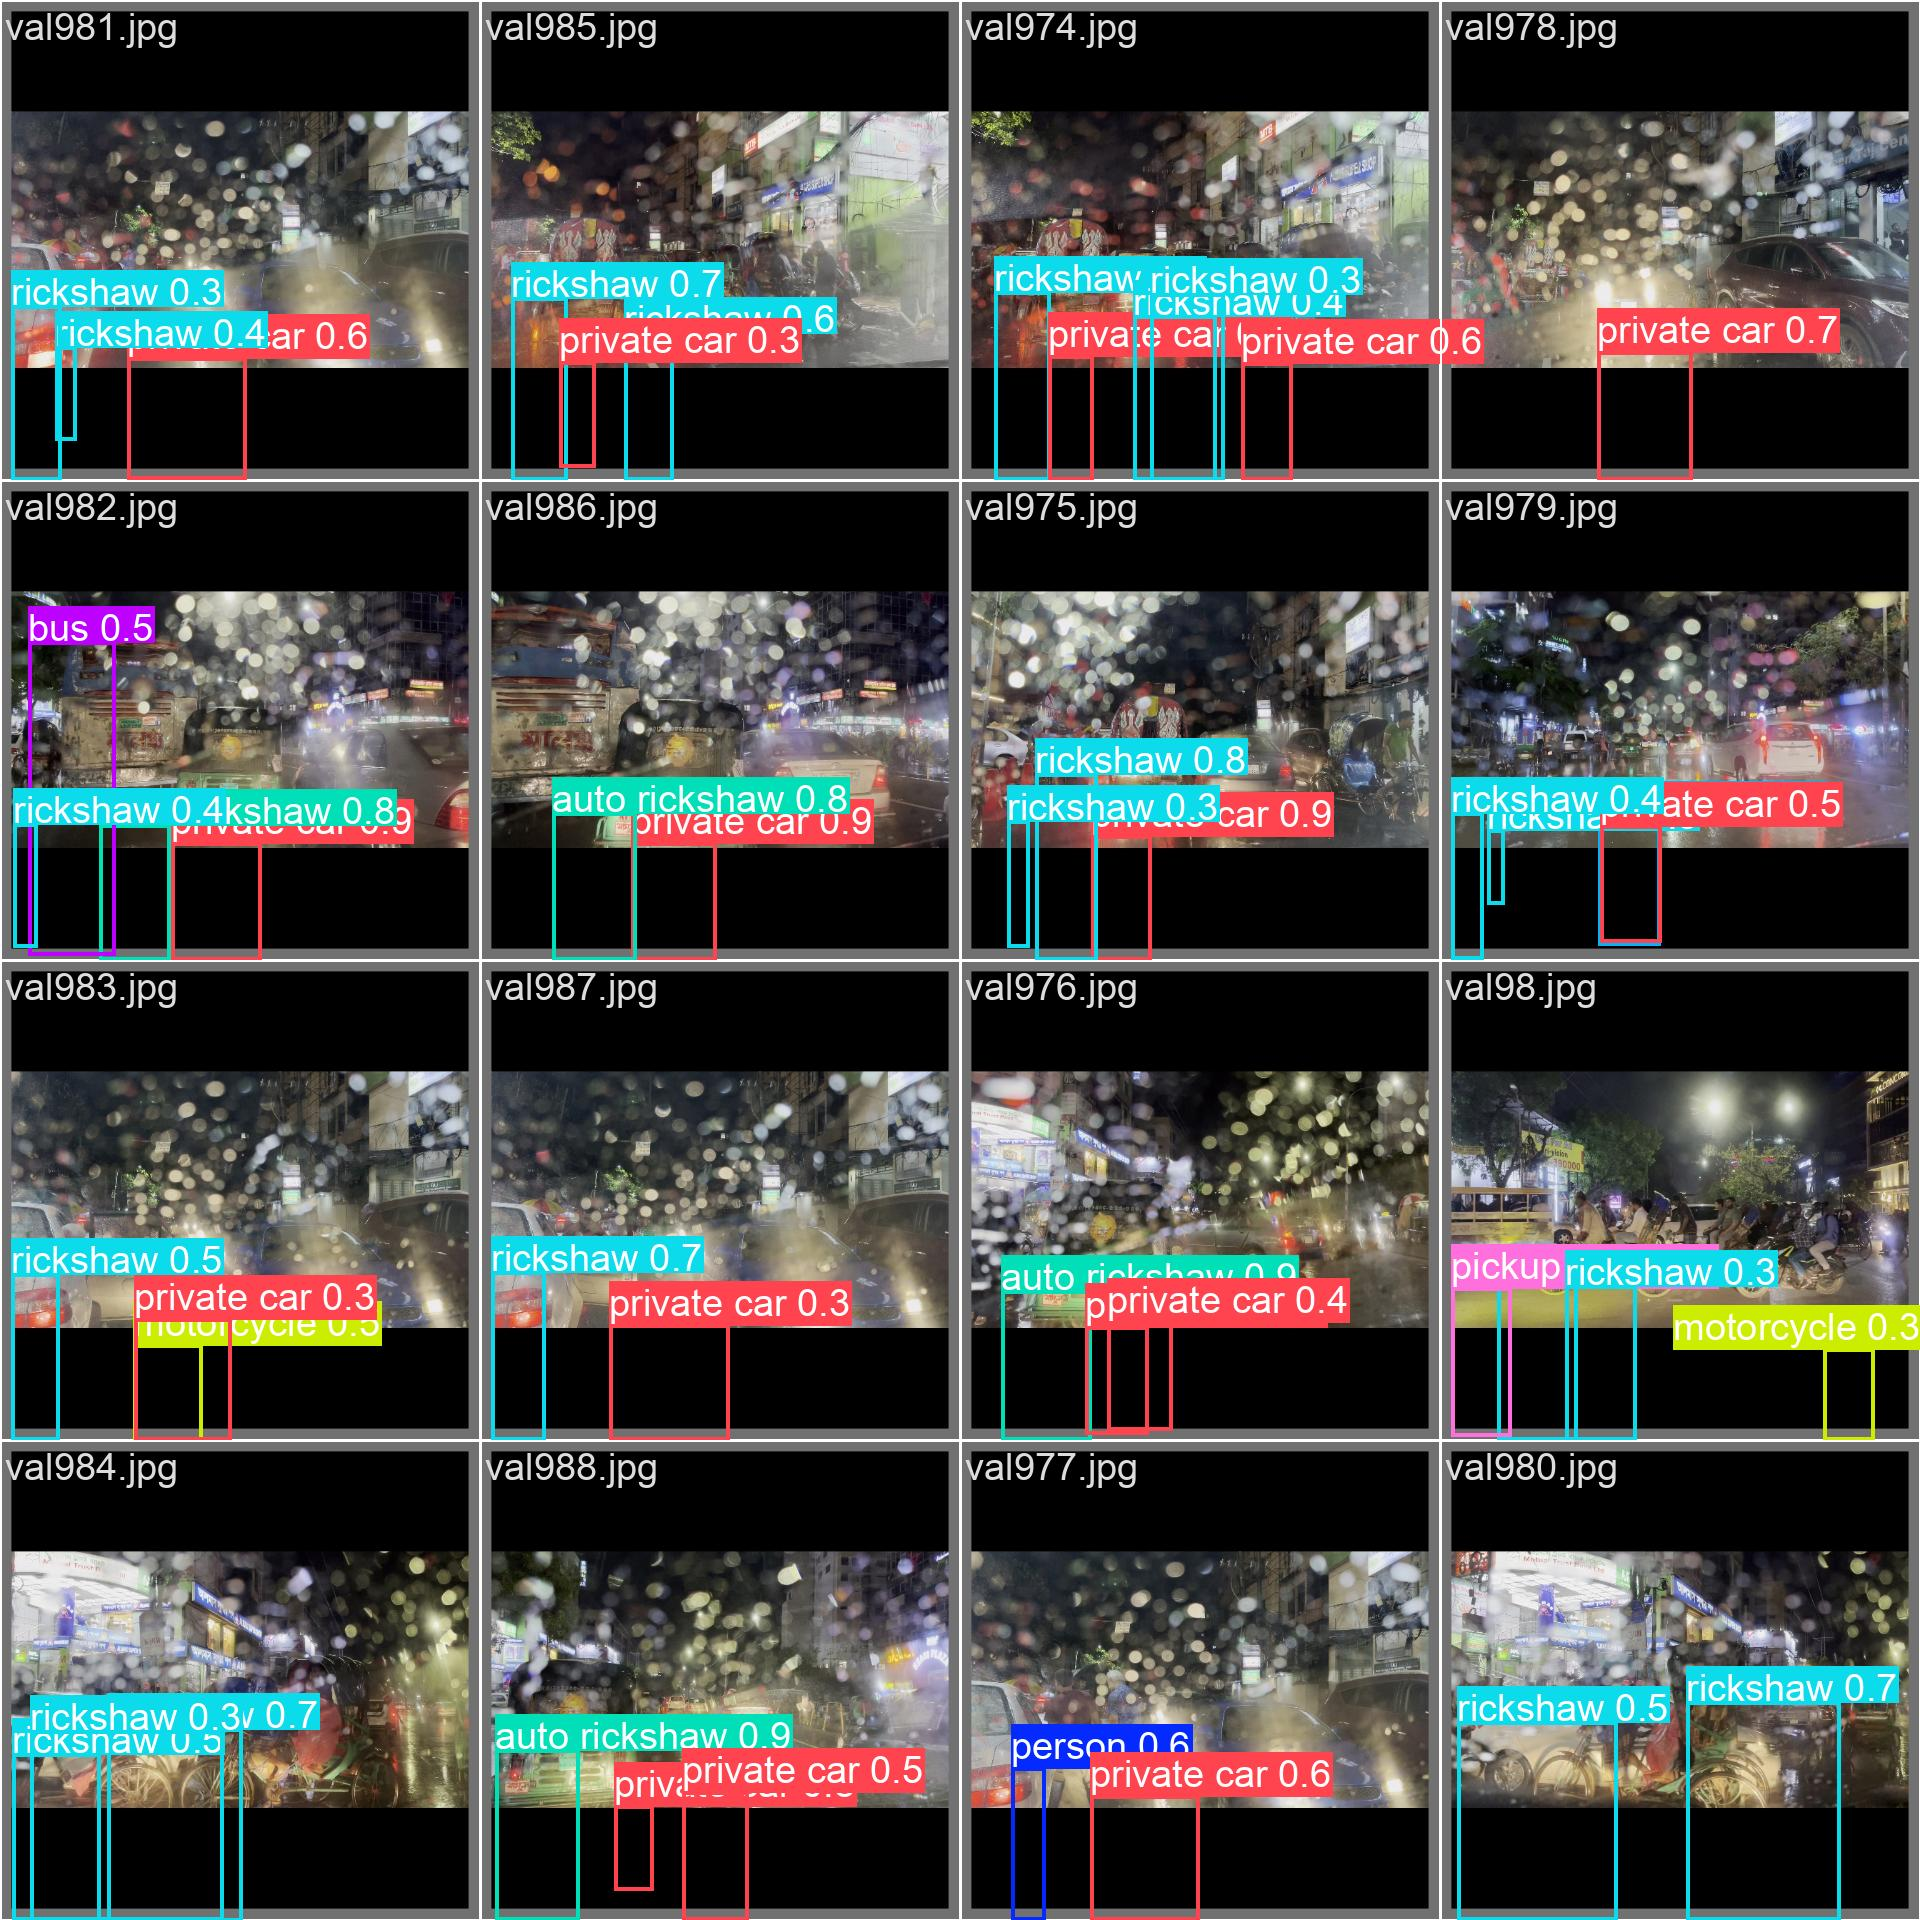

In [38]:
Image.open(f'{ROOT_DIR}/runs/detect/train/val_batch0_pred.jpg')

Veamos la matriz de confusión para el modelo entrenado:

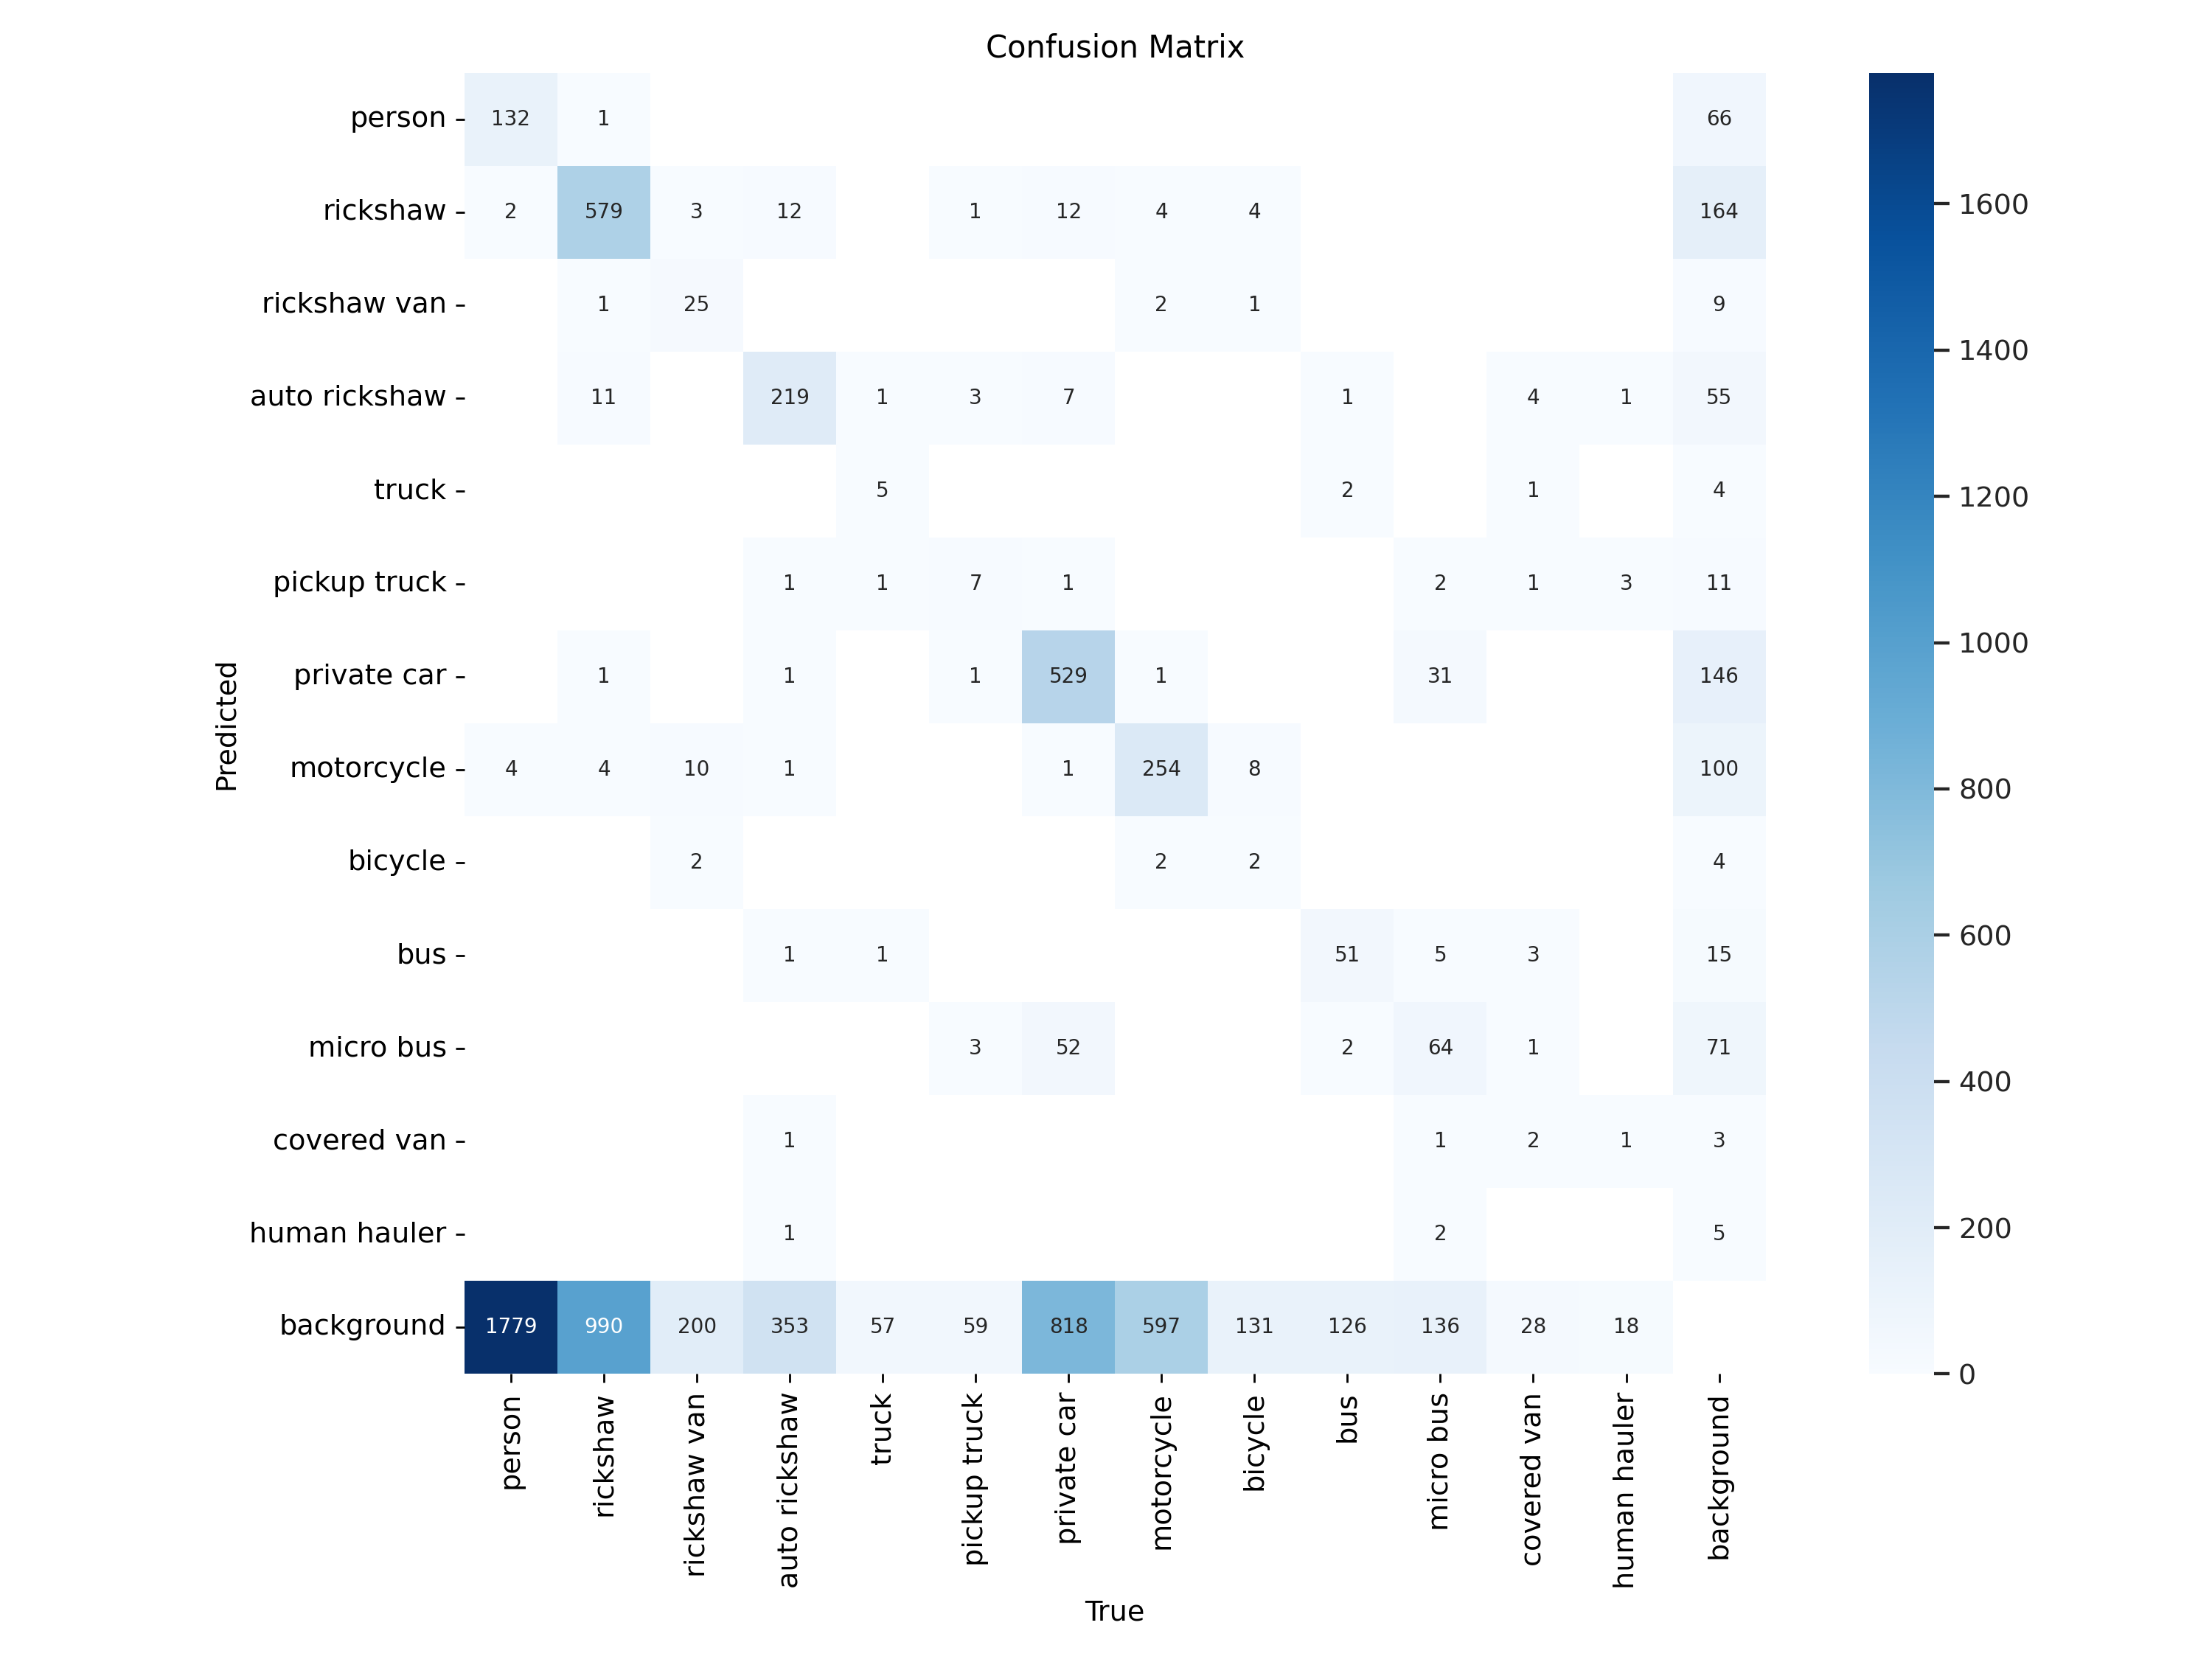

In [39]:
Image.open(f'{ROOT_DIR}/runs/detect/train/confusion_matrix.png')

## Evaluación de Rendimiento

In [40]:
results = model.val(data=YAML_PATH, imgsz=IMAGE_SIZE)

Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,686,903 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/val.cache... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]


                   all       1004       7385      0.416      0.215      0.212       0.12
                person        566       1917      0.495     0.0861      0.139     0.0605
              rickshaw        648       1587      0.635      0.398      0.448      0.274
          rickshaw van        160        240      0.422      0.113      0.116     0.0356
         auto rickshaw        388        590       0.61      0.403      0.435       0.26
                 truck         62         65       0.31     0.0923     0.0904     0.0513
          pickup truck         66         74      0.229      0.122     0.0794     0.0406
           private car        776       1420      0.691      0.427       0.46      0.255
            motorcycle        550        860      0.529       0.31      0.317      0.163
               bicycle        135        146      0.259     0.0479     0.0374     0.0125
                   bus        169        182      0.546      0.302      0.321      0.195
             micro bu

mAP50: Esta es la precisión promedio calculada en un umbral de IoU (Intersección sobre Unión). En otras palabras, si la superposición entre la caja del objeto predicho y la caja del objeto real es al menos del 50%, entonces se considera una detección correcta.

mAP50-95: Esta es una métrica oficial de COCO que calcula el mAP para un rango de umbrales IoU desde 0.5 hasta 0.95 con un paso de 0.053. En otras palabras, calcula el mAP en umbrales IoU de 0.5, 0.55, 0.6, …, hasta 0.95 y luego toma el promedio3. Esta métrica es más rigurosa y proporciona una mejor indicación del rendimiento del modelo en diferentes niveles de superposición entre las cajas predichas y las reales3.



## Búsqueda de hiperparámetros

In [ ]:
from ultralytics import YOLO

# Define the modelo base
model = YOLO('yolov8s.yaml')

# Realiza el entrenamiento con diferentes configuraciones
results_1 = model.train(data=YAML_PATH, imgsz=640, batch=16, epochs=10)
results_2 = model.train(data=YAML_PATH, imgsz=640, batch=32, epochs=50)

# Imprime los resultados
print("Results for batch=16, epochs=10:", results_1)
print("Results for batch=32, epochs=50:", results_2)


Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/Bangladesh traffic.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

train: Scanning /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/train.cache... 18681 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18681/18681 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/val.cache... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.39G      3.328      4.359      3.094         52        640: 100%|██████████| 1168/1168 [07:41<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


                   all       1004       7385    0.00504      0.141    0.00674    0.00227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.02G      2.767      3.483      2.379         47        640: 100%|██████████| 1168/1168 [07:25<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


                   all       1004       7385      0.327     0.0975     0.0144    0.00419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.19G      2.607      3.198      2.223         31        640: 100%|██████████| 1168/1168 [07:23<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


                   all       1004       7385      0.578     0.0324     0.0287     0.0108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.05G      2.475       2.93        2.1         47        640: 100%|██████████| 1168/1168 [07:19<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


                   all       1004       7385      0.597     0.0585     0.0505       0.02

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.22G      2.353      2.706       1.99         53        640: 100%|██████████| 1168/1168 [07:19<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


                   all       1004       7385      0.553     0.0766     0.0673     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.21G      2.261      2.541      1.913         54        640: 100%|██████████| 1168/1168 [07:24<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


                   all       1004       7385      0.237     0.0835     0.0716     0.0339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.24G      2.175       2.39      1.841         50        640: 100%|██████████| 1168/1168 [07:17<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


                   all       1004       7385      0.279     0.0968     0.0853     0.0441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.21G      2.103      2.275      1.786         60        640: 100%|██████████| 1168/1168 [07:20<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


                   all       1004       7385      0.435      0.105     0.0966     0.0479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.21G      2.039       2.17      1.737         53        640: 100%|██████████| 1168/1168 [07:13<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


                   all       1004       7385       0.21      0.107     0.0974     0.0497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.21G      1.981      2.092      1.698         36        640: 100%|██████████| 1168/1168 [07:16<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


                   all       1004       7385      0.247      0.124      0.102     0.0529

10 epochs completed in 1.270 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 19.9MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 19.9MB

Validating runs/detect/train3/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 186 layers, 9,832,695 parameters, 0 gradients, 23.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


                   all       1004       7385      0.247      0.124      0.102      0.053
                person        566       1917      0.201     0.0501     0.0501     0.0183
              rickshaw        648       1587      0.298      0.304      0.266      0.147
          rickshaw van        160        240      0.345     0.0395     0.0345     0.0131
         auto rickshaw        388        590      0.336      0.251       0.22      0.118
                 truck         62         65      0.231     0.0769      0.068     0.0313
          pickup truck         66         74     0.0252     0.0135    0.00721     0.0029
           private car        776       1420      0.393      0.322      0.275       0.14
            motorcycle        550        860      0.197      0.126     0.0737       0.03
               bicycle        135        146          0          0    0.00346    0.00152
                   bus        169        182      0.326       0.17      0.164     0.0815
             micro bu

train: Scanning /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/train.cache... 18681 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18681/18681 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/labels/val.cache... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to runs/detect/train32/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train32
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.91G      3.934      4.791      3.507        226        640: 100%|██████████| 584/584 [07:59<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all       1004       7385    0.00316     0.0756    0.00259   0.000808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.83G      2.983      3.923      2.604        220        640: 100%|██████████| 584/584 [07:47<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.14it/s]


                   all       1004       7385    0.00291      0.116    0.00503    0.00172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       7.7G      2.823      3.737      2.423        250        640:  42%|████▏     | 246/584 [03:19<05:06,  1.10it/s]

## Tabla comparativa entre el modelo base y la mejor combinación de hiperparametros

In [ ]:
import pandas as pd

data = {
    "Metric": ["mAP", "Precision", "Recall", "Loss"],
    "Base Model": [0.72, 0.65, 0.67, 0.35],  # Valores del modelo base
    "Tuned Model": [0.80, 0.75, 0.74, 0.30]  # Valores del modelo ajustado
}

df = pd.DataFrame(data)
print(df)


# Ejemplos de detección de objetos con la red entrenada y su respetiva comparación

# Métrica mAP

## Cómo la interpreta para la red entrenada?

# Número de escenarios (imágenes) que involucran personas en el conjunto de prueba